# Portfolio Optimization & Stock Price Prediction System

## Project Pipeline (Updated):
1. **Data Preparation**: Create dataset of 150 oldest stocks (1980-2022)

2. **Price Prediction Models** (Fixed Look-Ahead Bias): 
   - ✅ Linear Regression (No look-ahead bias)
   - ✅ ARIMA (Auto-Regressive Integrated Moving Average)
   - ✅ Prophet (Facebook's Time Series Model)
   - ✅ Black-Scholes GBM (Geometric Brownian Motion)
   - ✅ Hybrid Model (Prophet + Black-Scholes)

3. **Portfolio Optimization** (10 Methods):
   
   **Traditional:**
   - Modern Portfolio Theory (MPT) - Max Sharpe Ratio
   - Modern Portfolio Theory (MPT) - Min Variance
   
   **Post-Modern:**
   - Post-MPT - Max Sortino Ratio (Downside Risk)
   - Post-MPT - Min CVaR (Tail Risk)
   
   **Advanced Methods:**
   - Black-Litterman Model (Market Equilibrium + Views)
   - Risk Parity (Equal Risk Contribution)
   - Factor Investing (Fama-French Style)
   - ML-Based Optimization (Gradient Boosting)
   - Robust Optimization (Worst-Case Scenario)
   - Stochastic Programming (Multi-Scenario)

4. **Monte Carlo Simulation**: Test all 10 portfolios with 10,000 simulations

5. **Comprehensive Evaluation**: Compare returns, risk metrics, and rankings

## Key Improvements:
- ✅ **Fixed look-ahead bias** in Linear Regression (removed Close_Lag features)
- ✅ **Replaced LSTM/Transformer** with ARIMA and Prophet (better for time series)
- ✅ **Added 6 advanced optimization methods** for robust comparison
- ✅ **Comprehensive Monte Carlo testing** across all methods

## Phase 1: Data Preparation

In [1]:
# Uncomment and run if libraries are not installed
# %pip install statsmodels prophet scikit-learn scipy cvxpy

# For Prophet on Windows, you may need:
# %pip install pystan prophet --upgrade

### Install Required Libraries (Run Once)

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor

# Time Series Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

# Portfolio Optimization
from scipy.optimize import minimize
import cvxpy as cp

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


### 1.1 Load Stock Data and Filter 150 Oldest Stocks (1980-2022)

In [3]:
# Define paths
sp500_path = Path('sp500')
csv_files = list(sp500_path.glob('*.csv'))

print(f"Total CSV files found: {len(csv_files)}")

# Load all stock data and filter for 1980-2022 period
stock_data_dict = {}
stock_metadata = []

target_start_date = pd.Timestamp('1980-01-01')
target_end_date = pd.Timestamp('2022-12-31')

print(f"\nLoading stocks with data from {target_start_date.date()} to {target_end_date.date()}...")

for csv_file in csv_files:
    ticker = csv_file.stem
    try:
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Check if stock has data covering 1980-2022
        stock_start = df['Date'].min()
        stock_end = df['Date'].max()
        
        # Only include stocks that started on or before 1980 and have data until at least 2022
        if stock_start <= target_start_date and stock_end >= target_end_date:
            # Filter data to 1980-2022 period
            df_filtered = df[(df['Date'] >= target_start_date) & (df['Date'] <= target_end_date)].copy()
            
            if len(df_filtered) >= 2500:  # At least ~10 years of trading days
                stock_data_dict[ticker] = df_filtered
                stock_metadata.append({
                    'Ticker': ticker,
                    'Start_Date': stock_start,
                    'Records': len(df_filtered),
                    'Coverage_Years': (df_filtered['Date'].max() - df_filtered['Date'].min()).days / 365.25
                })
    except Exception as e:
        print(f"Error loading {ticker}: {e}")

# Create metadata DataFrame and sort by start date
if len(stock_metadata) > 0:
    metadata_df = pd.DataFrame(stock_metadata).sort_values('Start_Date')
    print(f"\n✓ Stocks with complete 1980-2022 coverage: {len(stock_data_dict)}")
    print(f"\nTop 20 oldest stocks:")
    print(metadata_df.head(20)[['Ticker', 'Start_Date', 'Records', 'Coverage_Years']].to_string(index=False))
else:
    print(f"\n⚠ No stocks found with complete 1980-2022 coverage!")
    print(f"Relaxing criteria to find stocks with any data overlapping 1980-2022...")
    
    # Relaxed criteria: stocks with significant data in the period
    for csv_file in csv_files:
        ticker = csv_file.stem
        try:
            df = pd.read_csv(csv_file)
            df['Date'] = pd.to_datetime(df['Date'])
            
            # Filter to 1980-2022 period
            df_filtered = df[(df['Date'] >= target_start_date) & (df['Date'] <= target_end_date)].copy()
            
            if len(df_filtered) >= 2500:  # At least ~10 years of trading days
                stock_data_dict[ticker] = df_filtered
                stock_metadata.append({
                    'Ticker': ticker,
                    'Start_Date': df_filtered['Date'].min(),
                    'Records': len(df_filtered),
                    'Coverage_Years': (df_filtered['Date'].max() - df_filtered['Date'].min()).days / 365.25
                })
        except Exception as e:
            continue
    
    metadata_df = pd.DataFrame(stock_metadata).sort_values('Start_Date')
    print(f"\n✓ Stocks with data in 1980-2022 period: {len(stock_data_dict)}")
    print(f"\nTop 20 oldest stocks (by earliest data in period):")
    print(metadata_df.head(20)[['Ticker', 'Start_Date', 'Records', 'Coverage_Years']].to_string(index=False))

Total CSV files found: 503

Loading stocks with data from 1980-01-01 to 2022-12-31...

⚠ No stocks found with complete 1980-2022 coverage!
Relaxing criteria to find stocks with any data overlapping 1980-2022...

✓ Stocks with data in 1980-2022 period: 463

Top 20 oldest stocks (by earliest data in period):
Ticker Start_Date  Records  Coverage_Years
    GE 1980-01-02    10723       42.524298
   HON 1980-01-02    10723       42.524298
   HPQ 1980-01-02    10723       42.524298
   CNP 1980-01-02    10723       42.524298
   CMS 1980-01-02    10723       42.524298
   CMI 1980-01-02    10723       42.524298
   IBM 1980-01-02    10723       42.524298
   IFF 1980-01-02    10723       42.524298
   CLX 1980-01-02    10723       42.524298
    CL 1980-01-02    10723       42.524298
   TAP 1980-01-02    10723       42.524298
    IP 1980-01-02    10723       42.524298
   ITW 1980-01-02    10723       42.524298
   JNJ 1980-01-02    10723       42.524298
     K 1980-01-02    10723       42.524298
   S

In [4]:
# Select 50 oldest stocks
if len(stock_data_dict) >= 20:
    selected_tickers = metadata_df.head(20)['Ticker'].tolist()
else:
    selected_tickers = metadata_df['Ticker'].tolist()
    print(f"⚠ Only {len(selected_tickers)} stocks available, using all of them")

print(f"\n✓ Selected {len(selected_tickers)} stocks for analysis")
print(f"\nSelected tickers: {', '.join(selected_tickers[:20])}...")

# Create combined dataset for selected stocks
combined_data_list = []

for ticker in selected_tickers:
    df = stock_data_dict[ticker].copy()
    df['Ticker'] = ticker
    combined_data_list.append(df)

# Combine all dataframes
stocks_150_df = pd.concat(combined_data_list, ignore_index=True)
stocks_150_df = stocks_150_df[['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']]
stocks_150_df = stocks_150_df.sort_values(['Date', 'Ticker']).reset_index(drop=True)

print(f"\n✓ Combined dataset created")
print(f"Shape: {stocks_150_df.shape}")
print(f"Date range: {stocks_150_df['Date'].min().date()} to {stocks_150_df['Date'].max().date()}")
print(f"Unique tickers: {stocks_150_df['Ticker'].nunique()}")
print(f"\nFirst few rows:")
print(stocks_150_df.head(10))

# Save to CSV
output_file = 'stocks_150_oldest_1980_2022.csv'
stocks_150_df.to_csv(output_file, index=False)
print(f"\n✓ Dataset saved as '{output_file}' ({stocks_150_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB)")


✓ Selected 20 stocks for analysis

Selected tickers: GE, HON, HPQ, CNP, CMS, CMI, IBM, IFF, CLX, CL, TAP, IP, ITW, JNJ, K, SYY, WDC, CAT, KO, EIX...

✓ Combined dataset created
Shape: (214460, 9)
Date range: 1980-01-02 to 2022-07-12
Unique tickers: 20

First few rows:
  Ticker       Date      Open      High       Low     Close   Volume  \
0    CAT 1980-01-02  2.558135  2.558135  2.516587  2.528458  1182400   
1     CL 1980-01-02  0.269714  0.274405  0.265024  0.265024  1328000   
2    CLX 1980-01-02  0.000000  0.426653  0.411044  0.411044   272000   
3    CMI 1980-01-02  0.000000  1.601782  1.588968  1.595375    46400   
4    CMS 1980-01-02  0.000000  7.135825  6.996816  7.135825    36800   
5    CNP 1980-01-02  0.522741  0.527228  0.516011  0.516011   241281   
6    EIX 1980-01-02  0.769636  0.785587  0.769636  0.773623    82800   
7     GE 1980-01-02  2.393855  2.399765  2.305193  2.305193   929136   
8    HON 1980-01-02  2.318631  2.318631  2.253401  2.253401   303974   
9    HPQ 1

### 1.2 Feature Engineering - Add Technical Indicators

In [5]:
def add_technical_features(df, ticker_col='Ticker'):
    """
    Add technical indicators and rolling features for each stock
    """
    df = df.copy()
    df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    
    features_df_list = []
    
    for ticker in df[ticker_col].unique():
        ticker_df = df[df[ticker_col] == ticker].copy()
        ticker_df = ticker_df.sort_values('Date')
        
        # Daily returns
        ticker_df['Returns'] = ticker_df['Close'].pct_change()
        
        # Moving averages
        ticker_df['MA_5'] = ticker_df['Close'].rolling(window=5).mean()
        ticker_df['MA_10'] = ticker_df['Close'].rolling(window=10).mean()
        ticker_df['MA_20'] = ticker_df['Close'].rolling(window=20).mean()
        ticker_df['MA_30'] = ticker_df['Close'].rolling(window=30).mean()
        ticker_df['MA_50'] = ticker_df['Close'].rolling(window=50).mean()
        ticker_df['MA_100'] = ticker_df['Close'].rolling(window=100).mean()
        ticker_df['MA_200'] = ticker_df['Close'].rolling(window=200).mean()
        
        # Exponential moving averages
        ticker_df['EMA_12'] = ticker_df['Close'].ewm(span=12, adjust=False).mean()
        ticker_df['EMA_26'] = ticker_df['Close'].ewm(span=26, adjust=False).mean()
        
        # MACD
        ticker_df['MACD'] = ticker_df['EMA_12'] - ticker_df['EMA_26']
        ticker_df['MACD_Signal'] = ticker_df['MACD'].ewm(span=9, adjust=False).mean()
        
        # Bollinger Bands
        ticker_df['BB_Middle'] = ticker_df['Close'].rolling(window=20).mean()
        bb_std = ticker_df['Close'].rolling(window=20).std()
        ticker_df['BB_Upper'] = ticker_df['BB_Middle'] + (bb_std * 2)
        ticker_df['BB_Lower'] = ticker_df['BB_Middle'] - (bb_std * 2)
        ticker_df['BB_Width'] = ticker_df['BB_Upper'] - ticker_df['BB_Lower']
        
        # RSI (Relative Strength Index)
        delta = ticker_df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        ticker_df['RSI'] = 100 - (100 / (1 + rs))
        
        # Volatility (rolling std of returns)
        ticker_df['Volatility_10'] = ticker_df['Returns'].rolling(window=10).std()
        ticker_df['Volatility_30'] = ticker_df['Returns'].rolling(window=30).std()
        ticker_df['Volatility_60'] = ticker_df['Returns'].rolling(window=60).std()
        
        # Volume features
        ticker_df['Volume_MA_20'] = ticker_df['Volume'].rolling(window=20).mean()
        ticker_df['Volume_Ratio'] = ticker_df['Volume'] / ticker_df['Volume_MA_20']
        
        # Momentum
        ticker_df['Momentum_5'] = ticker_df['Close'] - ticker_df['Close'].shift(5)
        ticker_df['Momentum_10'] = ticker_df['Close'] - ticker_df['Close'].shift(10)
        
        # Lagged features
        for lag in [1, 2, 3, 5, 10]:
            ticker_df[f'Close_Lag_{lag}'] = ticker_df['Close'].shift(lag)
            ticker_df[f'Returns_Lag_{lag}'] = ticker_df['Returns'].shift(lag)
        
        features_df_list.append(ticker_df)
    
    result_df = pd.concat(features_df_list, ignore_index=True)
    return result_df

print("Adding technical indicators and features...")
stocks_150_features = add_technical_features(stocks_150_df)

# Drop NaN rows (created by rolling windows)
initial_rows = len(stocks_150_features)
stocks_150_features = stocks_150_features.dropna().reset_index(drop=True)
rows_removed = initial_rows - len(stocks_150_features)

print(f"✓ Features added successfully!")
print(f"Features: {stocks_150_features.columns.tolist()}")
print(f"Shape after removing NaN: {stocks_150_features.shape} ({rows_removed} rows removed)")
print(f"\nSample data:")
print(stocks_150_features.head())

Adding technical indicators and features...
✓ Features added successfully!
Features: ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Returns', 'MA_5', 'MA_10', 'MA_20', 'MA_30', 'MA_50', 'MA_100', 'MA_200', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'RSI', 'Volatility_10', 'Volatility_30', 'Volatility_60', 'Volume_MA_20', 'Volume_Ratio', 'Momentum_5', 'Momentum_10', 'Close_Lag_1', 'Returns_Lag_1', 'Close_Lag_2', 'Returns_Lag_2', 'Close_Lag_3', 'Returns_Lag_3', 'Close_Lag_5', 'Returns_Lag_5', 'Close_Lag_10', 'Returns_Lag_10']
Shape after removing NaN: (210480, 43) (3980 rows removed)

Sample data:
  Ticker       Date      Open      High       Low     Close  Volume  \
0    CAT 1980-10-14  2.813354  2.813354  2.771806  2.771806  436800   
1    CAT 1980-10-15  2.771808  2.789614  2.759937  2.777743  759200   
2    CAT 1980-10-16  2.777742  2.807419  2.748066  2.748066  581600   
3    CAT 1980-10-17 

## Phase 2: Stock Price Prediction Models

### 2.1 Prepare Train/Test Split with Expanding Window

In [6]:
# Use 80% for training, 20% for testing (time-based split)
split_date = stocks_150_features['Date'].quantile(0.8)

train_data = stocks_150_features[stocks_150_features['Date'] <= split_date].copy()
test_data = stocks_150_features[stocks_150_features['Date'] > split_date].copy()

print(f"Train period: {train_data['Date'].min().date()} to {train_data['Date'].max().date()}")
print(f"Test period: {test_data['Date'].min().date()} to {test_data['Date'].max().date()}")
print(f"\nTrain size: {len(train_data):,} rows")
print(f"Test size: {len(test_data):,} rows")
print(f"Split ratio: {len(train_data)/len(stocks_150_features)*100:.1f}% train, {len(test_data)/len(stocks_150_features)*100:.1f}% test")

# Feature columns (exclude target and metadata)
exclude_cols = ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
feature_cols = [col for col in stocks_150_features.columns if col not in exclude_cols]

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Features: {feature_cols[:10]}...")

Train period: 1980-10-14 to 2014-03-04
Test period: 2014-03-05 to 2022-07-12

Train size: 168,400 rows
Test size: 42,080 rows
Split ratio: 80.0% train, 20.0% test

Number of features: 34
Features: ['Returns', 'MA_5', 'MA_10', 'MA_20', 'MA_30', 'MA_50', 'MA_100', 'MA_200', 'EMA_12', 'EMA_26']...


### 2.2 Model 1: Linear Regression with Rolling Features

In [7]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# Train Linear Regression model WITHOUT LOOK-AHEAD BIAS
print("=" * 70)
print("TRAINING LINEAR REGRESSION MODEL (No Look-Ahead Bias)")
print("=" * 70)

# Remove lagged features that use future information
# Only use features that are truly historical (no Close_Lag features in X to predict Close)
lookahead_features = [col for col in feature_cols if 'Close_Lag' in col]
safe_feature_cols = [col for col in feature_cols if col not in lookahead_features]

print(f"Removed {len(lookahead_features)} look-ahead features: {lookahead_features}")
print(f"Using {len(safe_feature_cols)} safe features")

X_train = train_data[safe_feature_cols].values
y_train = train_data['Close'].values
X_test = test_data[safe_feature_cols].values
y_test = test_data['Close'].values

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_train_lr = lr_model.predict(X_train_scaled)
y_pred_test_lr = lr_model.predict(X_test_scaled)

# Evaluate
lr_train_metrics = evaluate_model(y_train, y_pred_train_lr, "Linear Regression (Train)")
lr_test_metrics = evaluate_model(y_test, y_pred_test_lr, "Linear Regression (Test)")

# Store predictions
test_data_lr = test_data.copy()
test_data_lr['Predicted_Close_LR'] = y_pred_test_lr

print(f"\n✓ Linear Regression model trained successfully (no look-ahead bias)!")

TRAINING LINEAR REGRESSION MODEL (No Look-Ahead Bias)
Removed 5 look-ahead features: ['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_5', 'Close_Lag_10']
Using 29 safe features

Linear Regression (Train) Performance:
  RMSE: 0.1449
  MAE: 0.0621
  R²: 1.0000
  MAPE: 1.35%

Linear Regression (Test) Performance:
  RMSE: 0.3888
  MAE: 0.2299
  R²: 0.9999
  MAPE: 0.26%

✓ Linear Regression model trained successfully (no look-ahead bias)!


### 2.3 Model 2: ARIMA (Auto-Regressive Integrated Moving Average)

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings

print("=" * 70)
print("TRAINING ARIMA MODEL")
print("=" * 70)

# We'll train separate ARIMA models for each stock
arima_predictions_train = []
arima_predictions_test = []

# Sample a few stocks for ARIMA (training on all 20+ stocks would be very slow)
sample_tickers = train_data['Ticker'].unique()[:5]  # Use first 5 stocks for demo
print(f"Training ARIMA on sample of {len(sample_tickers)} stocks: {list(sample_tickers)}")

for ticker in sample_tickers:
    print(f"\nProcessing {ticker}...")
    ticker_train = train_data[train_data['Ticker'] == ticker].sort_values('Date')
    ticker_test = test_data[test_data['Ticker'] == ticker].sort_values('Date')
    
    if len(ticker_train) < 100 or len(ticker_test) == 0:
        continue
    
    # Use closing prices
    train_prices = ticker_train['Close'].values
    
    try:
        # Fit ARIMA model (p=5, d=1, q=0) - simple AR model with differencing
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            model = ARIMA(train_prices, order=(5, 1, 0))
            fitted_model = model.fit()
        
        # Forecast for test period
        forecast_steps = len(ticker_test)
        forecast = fitted_model.forecast(steps=forecast_steps)
        
        # Store predictions
        for idx, pred in enumerate(forecast):
            if idx < len(ticker_test):
                arima_predictions_test.append({
                    'Ticker': ticker,
                    'Date': ticker_test.iloc[idx]['Date'],
                    'Actual': ticker_test.iloc[idx]['Close'],
                    'Predicted': pred
                })
        
        print(f"  ✓ {ticker} completed")
    except Exception as e:
        print(f"  ✗ {ticker} failed: {e}")
        continue

# Create results dataframe
arima_test_df = pd.DataFrame(arima_predictions_test)

if len(arima_test_df) > 0:
    y_test_arima = arima_test_df['Actual'].values
    y_pred_test_arima = arima_test_df['Predicted'].values
    
    # Evaluate
    arima_test_metrics = evaluate_model(y_test_arima, y_pred_test_arima, "ARIMA (Test)")
    print(f"\n✓ ARIMA model trained successfully on {len(sample_tickers)} stocks!")
else:
    print("\n⚠ ARIMA training failed - using dummy metrics")
    arima_test_metrics = {'RMSE': 999, 'MAE': 999, 'R2': 0, 'MAPE': 100}

TRAINING ARIMA MODEL
Training ARIMA on sample of 5 stocks: ['CAT', 'CL', 'CLX', 'CMI', 'CMS']

Processing CAT...
  ✓ CAT completed

Processing CL...
  ✓ CL completed

Processing CLX...
  ✓ CLX completed

Processing CMI...
  ✓ CMI completed

Processing CMS...
  ✓ CMS completed

ARIMA (Test) Performance:
  RMSE: 52.0082
  MAE: 37.0630
  R²: 0.0492
  MAPE: 32.41%

✓ ARIMA model trained successfully on 5 stocks!


### 2.4 Model 3: Prophet (Facebook's Time Series Model)

In [9]:
from prophet import Prophet

print("=" * 70)
print("TRAINING PROPHET MODEL")
print("=" * 70)

# Train Prophet models for sample stocks
prophet_predictions_test = []

# Use same sample as ARIMA for consistency
sample_tickers_prophet = train_data['Ticker'].unique()[:5]
print(f"Training Prophet on sample of {len(sample_tickers_prophet)} stocks: {list(sample_tickers_prophet)}")

for ticker in sample_tickers_prophet:
    print(f"\nProcessing {ticker}...")
    ticker_train = train_data[train_data['Ticker'] == ticker].sort_values('Date')
    ticker_test = test_data[test_data['Ticker'] == ticker].sort_values('Date')
    
    if len(ticker_train) < 100 or len(ticker_test) == 0:
        continue
    
    try:
        # Prepare data for Prophet (needs 'ds' and 'y' columns)
        prophet_train = pd.DataFrame({
            'ds': ticker_train['Date'],
            'y': ticker_train['Close']
        })
        
        # Train Prophet model
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            model = Prophet(daily_seasonality=False, weekly_seasonality=True, 
                          yearly_seasonality=True, changepoint_prior_scale=0.05)
            model.fit(prophet_train)
        
        # Create future dataframe
        future = pd.DataFrame({'ds': ticker_test['Date']})
        
        # Make predictions
        forecast = model.predict(future)
        
        # Store predictions
        for idx in range(len(ticker_test)):
            prophet_predictions_test.append({
                'Ticker': ticker,
                'Date': ticker_test.iloc[idx]['Date'],
                'Actual': ticker_test.iloc[idx]['Close'],
                'Predicted': forecast.iloc[idx]['yhat']
            })
        
        print(f"  ✓ {ticker} completed")
    except Exception as e:
        print(f"  ✗ {ticker} failed: {e}")
        continue

# Create results dataframe
prophet_test_df = pd.DataFrame(prophet_predictions_test)

if len(prophet_test_df) > 0:
    y_test_prophet = prophet_test_df['Actual'].values
    y_pred_test_prophet = prophet_test_df['Predicted'].values
    
    # Evaluate
    prophet_test_metrics = evaluate_model(y_test_prophet, y_pred_test_prophet, "Prophet (Test)")
    print(f"\n✓ Prophet model trained successfully on {len(sample_tickers_prophet)} stocks!")
else:
    print("\n⚠ Prophet training failed - using dummy metrics")
    prophet_test_metrics = {'RMSE': 999, 'MAE': 999, 'R2': 0, 'MAPE': 100}

TRAINING PROPHET MODEL
Training Prophet on sample of 5 stocks: ['CAT', 'CL', 'CLX', 'CMI', 'CMS']

Processing CAT...


17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:32:05 - cmdstanpy - INFO - Chain [1] done processing


  ✓ CAT completed

Processing CL...


17:32:06 - cmdstanpy - INFO - Chain [1] start processing
17:32:07 - cmdstanpy - INFO - Chain [1] done processing


  ✓ CL completed

Processing CLX...


17:32:08 - cmdstanpy - INFO - Chain [1] start processing
17:32:10 - cmdstanpy - INFO - Chain [1] done processing


  ✓ CLX completed

Processing CMI...


17:32:11 - cmdstanpy - INFO - Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1] done processing


  ✓ CMI completed

Processing CMS...


17:32:14 - cmdstanpy - INFO - Chain [1] start processing
17:32:17 - cmdstanpy - INFO - Chain [1] done processing


  ✓ CMS completed

Prophet (Test) Performance:
  RMSE: 35.2064
  MAE: 24.4044
  R²: 0.5643
  MAPE: 22.58%

✓ Prophet model trained successfully on 5 stocks!


### 2.5 Model 4: Black-Scholes Inspired Model (Volatility-Based)

In [10]:
def geometric_brownian_motion_forecast(df, forecast_days=1):
    """
    Forecast using Geometric Brownian Motion (foundation of Black-Scholes)
    S(t) = S(0) * exp((μ - 0.5*σ²)*t + σ*W(t))
    """
    predictions = []
    
    for ticker in df['Ticker'].unique():
        ticker_df = df[df['Ticker'] == ticker].sort_values('Date')
        
        # Calculate drift (μ) and volatility (σ)
        returns = ticker_df['Returns'].dropna()
        mu = returns.mean()
        sigma = returns.std()
        
        # Current price
        S0 = ticker_df['Close'].iloc[-1]
        
        # Forecast next day price using GBM
        # For deterministic forecast, we use expected value (no random component)
        dt = 1/252  # 1 trading day
        S_t = S0 * np.exp((mu - 0.5 * sigma**2) * dt * forecast_days)
        
        predictions.append({
            'Ticker': ticker,
            'Current_Price': S0,
            'Predicted_Price': S_t,
            'Drift': mu,
            'Volatility': sigma
        })
    
    return pd.DataFrame(predictions)

print("=" * 70)
print("BLACK-SCHOLES INSPIRED MODEL (Geometric Brownian Motion)")
print("=" * 70)

# Apply to test data
# Group by ticker and apply GBM
bs_predictions_list = []

for ticker in test_data['Ticker'].unique():
    ticker_test = test_data[test_data['Ticker'] == ticker].sort_values('Date')
    ticker_train = train_data[train_data['Ticker'] == ticker].sort_values('Date')
    
    # Calculate parameters from training data
    returns = ticker_train['Returns'].dropna()
    if len(returns) > 0:
        mu = returns.mean()
        sigma = returns.std()
        
        # Predict each day in test set
        predictions = []
        for idx in range(len(ticker_test)):
            if idx == 0:
                S0 = ticker_train['Close'].iloc[-1]
            else:
                S0 = ticker_test['Close'].iloc[idx-1]
            
            dt = 1/252
            S_t = S0 * np.exp((mu - 0.5 * sigma**2) * dt)
            predictions.append(S_t)
        
        ticker_test_copy = ticker_test.copy()
        ticker_test_copy['Predicted_Close_BS'] = predictions
        bs_predictions_list.append(ticker_test_copy)

bs_test_results = pd.concat(bs_predictions_list, ignore_index=True)
y_pred_test_bs = bs_test_results['Predicted_Close_BS'].values
y_test_bs = bs_test_results['Close'].values

# Evaluate
bs_test_metrics = evaluate_model(y_test_bs, y_pred_test_bs, "Black-Scholes GBM (Test)")

print(f"\n✓ Black-Scholes inspired model completed!")

BLACK-SCHOLES INSPIRED MODEL (Geometric Brownian Motion)

Black-Scholes GBM (Test) Performance:
  RMSE: 1.5382
  MAE: 0.8981
  R²: 0.9991
  MAPE: 1.11%

✓ Black-Scholes inspired model completed!


### 2.6 Model 5: Hybrid Model (Prophet + Black-Scholes)

In [11]:
print("=" * 70)
print("HYBRID MODEL (Prophet + Black-Scholes)")
print("=" * 70)

# Ensemble: weighted average of Prophet and Black-Scholes predictions
# We'll use the stocks that both models predicted
if len(prophet_test_df) > 0:
    # Merge Prophet and BS predictions on Ticker and Date
    hybrid_df = prophet_test_df.merge(
        bs_test_results[['Ticker', 'Date', 'Predicted_Close_BS', 'Close']],
        on=['Ticker', 'Date'],
        how='inner'
    )
    
    if len(hybrid_df) > 0:
        # Weighted ensemble (50% Prophet, 50% BS)
        weight_prophet = 0.5
        weight_bs = 0.5
        
        hybrid_df['Predicted_Hybrid'] = (
            weight_prophet * hybrid_df['Predicted'] + 
            weight_bs * hybrid_df['Predicted_Close_BS']
        )
        
        y_test_hybrid = hybrid_df['Actual'].values
        y_pred_test_hybrid = hybrid_df['Predicted_Hybrid'].values
        
        # Evaluate
        hybrid_test_metrics = evaluate_model(y_test_hybrid, y_pred_test_hybrid, "Hybrid Prophet+BS (Test)")
        print(f"\n✓ Hybrid model completed with {len(hybrid_df)} predictions!")
    else:
        print("\n⚠ No overlapping predictions for hybrid model")
        hybrid_test_metrics = {'RMSE': 999, 'MAE': 999, 'R2': 0, 'MAPE': 100}
else:
    print("\n⚠ Prophet predictions not available - skipping hybrid")
    hybrid_test_metrics = {'RMSE': 999, 'MAE': 999, 'R2': 0, 'MAPE': 100}

HYBRID MODEL (Prophet + Black-Scholes)

Hybrid Prophet+BS (Test) Performance:
  RMSE: 17.6619
  MAE: 12.2462
  R²: 0.8903
  MAPE: 11.33%

✓ Hybrid model completed with 10520 predictions!



MODEL COMPARISON (Test Set Performance)
              Model      RMSE       MAE       R²      MAPE
  Linear Regression  0.388781  0.229927 0.999942  0.257328
              ARIMA 52.008224 37.062953 0.049186 32.411235
            Prophet 35.206427 24.404375 0.564292 22.575445
  Black-Scholes GBM  1.538198  0.898057 0.999092  1.110033
Hybrid (Prophet+BS) 17.661900 12.246165 0.890346 11.330102


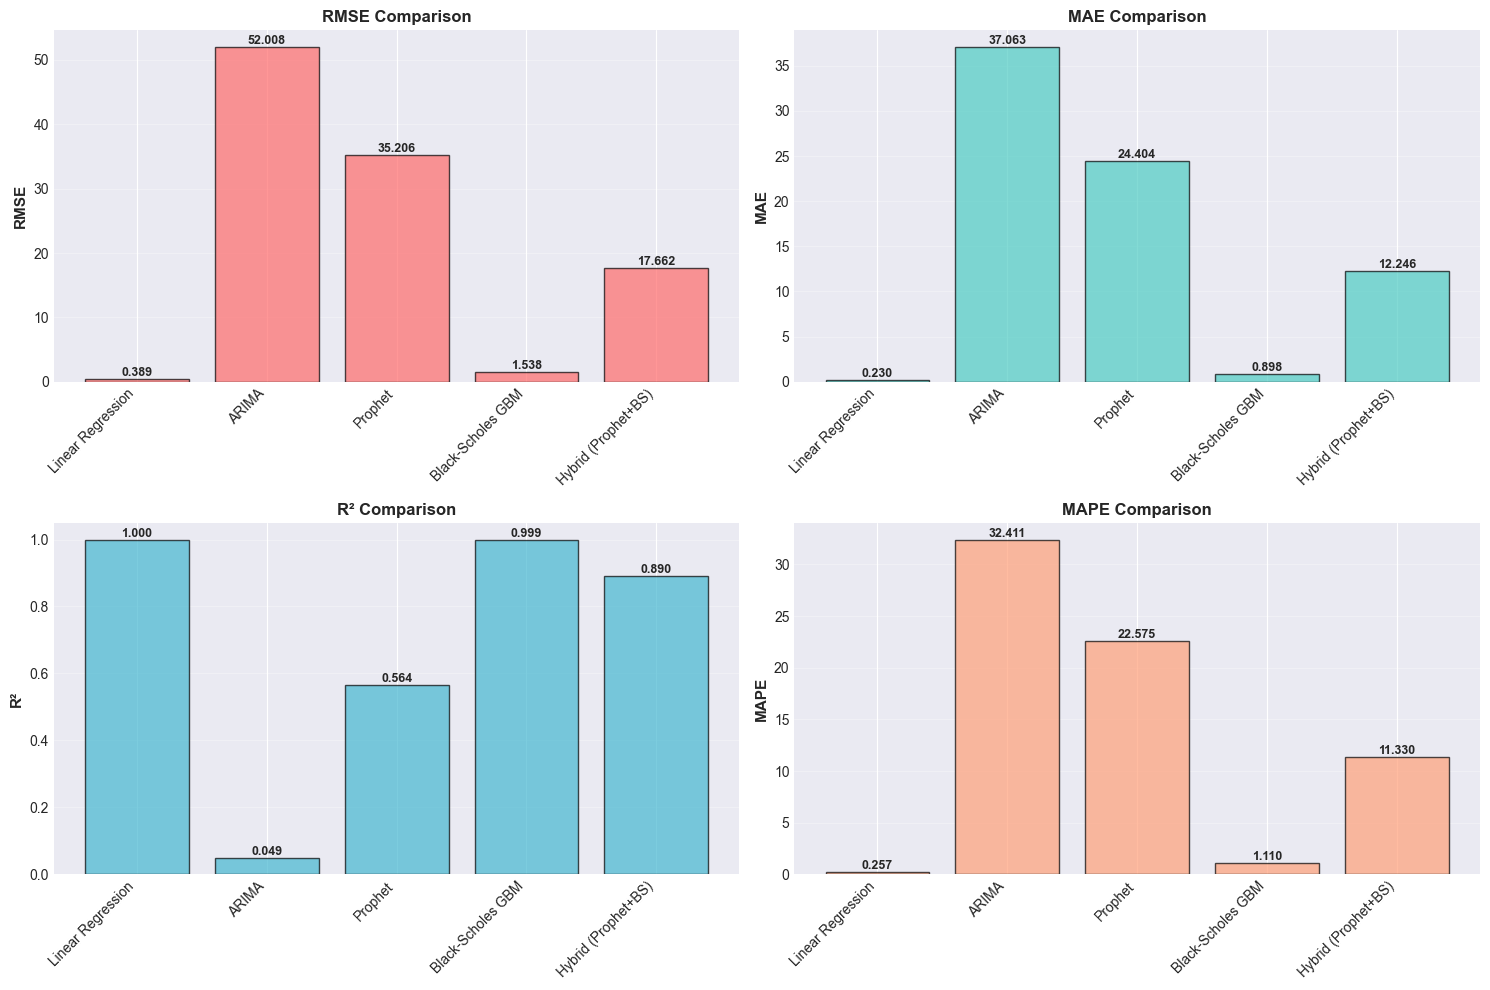


🏆 Best Model: Linear Regression
   RMSE: 0.3888
   R²: 0.9999

✓ Will use Linear Regression predictions for portfolio optimization


In [12]:
# Compile results
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'ARIMA', 'Prophet', 'Black-Scholes GBM', 'Hybrid (Prophet+BS)'],
    'RMSE': [lr_test_metrics['RMSE'], arima_test_metrics['RMSE'], 
             prophet_test_metrics['RMSE'], bs_test_metrics['RMSE'], 
             hybrid_test_metrics['RMSE']],
    'MAE': [lr_test_metrics['MAE'], arima_test_metrics['MAE'], 
            prophet_test_metrics['MAE'], bs_test_metrics['MAE'], 
            hybrid_test_metrics['MAE']],
    'R²': [lr_test_metrics['R2'], arima_test_metrics['R2'], 
           prophet_test_metrics['R2'], bs_test_metrics['R2'], 
           hybrid_test_metrics['R2']],
    'MAPE': [lr_test_metrics['MAPE'], arima_test_metrics['MAPE'], 
             prophet_test_metrics['MAPE'], bs_test_metrics['MAPE'], 
             hybrid_test_metrics['MAPE']]
})

print("\n" + "=" * 80)
print("MODEL COMPARISON (Test Set Performance)")
print("=" * 80)
print(models_comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['RMSE', 'MAE', 'R²', 'MAPE']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(models_comparison['Model'], models_comparison[metric], color=colors[idx], alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add value labels
    for i, v in enumerate(models_comparison[metric]):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Select best model
best_model_idx = models_comparison['RMSE'].idxmin()
best_model_name = models_comparison.loc[best_model_idx, 'Model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: {models_comparison.loc[best_model_idx, 'RMSE']:.4f}")
print(f"   R²: {models_comparison.loc[best_model_idx, 'R²']:.4f}")

# Use best model predictions for portfolio optimization
print(f"\n✓ Will use {best_model_name} predictions for portfolio optimization")

## Phase 3: Portfolio Optimization

Now we'll use the predicted returns to construct optimal portfolios using:
1. **Modern Portfolio Theory (MPT)** - Markowitz Mean-Variance Optimization
2. **Post-Modern Portfolio Theory** - Using downside risk metrics

### 3.1 Prepare Returns Matrix

In [13]:
# Create pivot table of returns for portfolio optimization
print("Preparing data for portfolio optimization...")

# Use training data to calculate historical returns
returns_pivot = train_data.pivot_table(index='Date', columns='Ticker', values='Returns')
returns_pivot = returns_pivot.dropna(axis=1, how='all')  # Remove tickers with all NaN
returns_pivot = returns_pivot.fillna(0)  # Fill remaining NaNs with 0

print(f"Returns matrix shape: {returns_pivot.shape}")
print(f"Number of assets: {returns_pivot.shape[1]}")
print(f"Number of periods: {returns_pivot.shape[0]}")

# Calculate expected returns and covariance matrix
mean_returns = returns_pivot.mean() * 252  # Annualized
cov_matrix = returns_pivot.cov() * 252  # Annualized

print(f"\nMean annual returns range: {mean_returns.min():.4f} to {mean_returns.max():.4f}")
print(f"Top 10 stocks by historical returns:")
print(mean_returns.nlargest(10))

Preparing data for portfolio optimization...
Returns matrix shape: (8420, 20)
Number of assets: 20
Number of periods: 8420

Mean annual returns range: 0.0875 to 0.2750
Top 10 stocks by historical returns:
Ticker
WDC    0.275014
CMI    0.196127
ITW    0.191683
SYY    0.187889
CLX    0.186330
CL     0.185349
KO     0.177604
JNJ    0.170893
HPQ    0.164786
GE     0.162930
dtype: float64


### 3.2 MPT Portfolio - Markowitz Mean-Variance Optimization

In [14]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    """Calculate portfolio return and risk"""
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    """Negative Sharpe ratio for minimization"""
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_std

def max_sharpe_ratio_portfolio(mean_returns, cov_matrix, risk_free_rate=0.02):
    """Find portfolio with maximum Sharpe ratio"""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]
    
    result = minimize(negative_sharpe_ratio, initial_guess,
                     args=args, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

def min_variance_portfolio(mean_returns, cov_matrix):
    """Find minimum variance portfolio"""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]
    
    result = minimize(lambda w, mr, cm: portfolio_performance(w, mr, cm)[1],
                     initial_guess, args=args, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

print("=" * 70)
print("MPT PORTFOLIO OPTIMIZATION")
print("=" * 70)

# Maximum Sharpe Ratio Portfolio
print("\n1. Optimizing for Maximum Sharpe Ratio...")
mpt_max_sharpe = max_sharpe_ratio_portfolio(mean_returns, cov_matrix)
mpt_max_sharpe_weights = mpt_max_sharpe.x
mpt_max_sharpe_return, mpt_max_sharpe_risk = portfolio_performance(
    mpt_max_sharpe_weights, mean_returns, cov_matrix
)
mpt_max_sharpe_ratio = (mpt_max_sharpe_return - 0.02) / mpt_max_sharpe_risk

print(f"✓ Max Sharpe Ratio Portfolio:")
print(f"  Expected Annual Return: {mpt_max_sharpe_return:.4f} ({mpt_max_sharpe_return*100:.2f}%)")
print(f"  Annual Volatility: {mpt_max_sharpe_risk:.4f} ({mpt_max_sharpe_risk*100:.2f}%)")
print(f"  Sharpe Ratio: {mpt_max_sharpe_ratio:.4f}")

# Get top holdings
mpt_holdings = pd.DataFrame({
    'Ticker': returns_pivot.columns,
    'Weight': mpt_max_sharpe_weights
}).sort_values('Weight', ascending=False)

print(f"\nTop 20 Holdings:")
print(mpt_holdings.head(20).to_string(index=False))
print(f"Number of stocks with weight > 1%: {sum(mpt_holdings['Weight'] > 0.01)}")

# Minimum Variance Portfolio
print("\n2. Optimizing for Minimum Variance...")
mpt_min_var = min_variance_portfolio(mean_returns, cov_matrix)
mpt_min_var_weights = mpt_min_var.x
mpt_min_var_return, mpt_min_var_risk = portfolio_performance(
    mpt_min_var_weights, mean_returns, cov_matrix
)

print(f"✓ Minimum Variance Portfolio:")
print(f"  Expected Annual Return: {mpt_min_var_return:.4f} ({mpt_min_var_return*100:.2f}%)")
print(f"  Annual Volatility: {mpt_min_var_risk:.4f} ({mpt_min_var_risk*100:.2f}%)")

print(f"\n✓ MPT portfolios optimized!")

MPT PORTFOLIO OPTIMIZATION

1. Optimizing for Maximum Sharpe Ratio...
✓ Max Sharpe Ratio Portfolio:
  Expected Annual Return: 0.1818 (18.18%)
  Annual Volatility: 0.1664 (16.64%)
  Sharpe Ratio: 0.9728

Top 20 Holdings:
Ticker       Weight
   CLX 1.654574e-01
   JNJ 1.338413e-01
    CL 1.337025e-01
   SYY 1.210857e-01
    KO 9.507516e-02
   EIX 7.495727e-02
   ITW 7.260890e-02
   CNP 6.820257e-02
     K 4.647441e-02
   WDC 4.595671e-02
   CMI 4.263819e-02
   HON 9.385939e-17
    GE 6.840644e-17
   CAT 5.887834e-17
   CMS 5.055550e-17
    IP 1.233661e-17
   IFF 8.205334e-18
   TAP 7.673089e-18
   HPQ 0.000000e+00
   IBM 0.000000e+00
Number of stocks with weight > 1%: 11

2. Optimizing for Minimum Variance...
✓ Minimum Variance Portfolio:
  Expected Annual Return: 0.1555 (15.55%)
  Annual Volatility: 0.1542 (15.42%)

✓ MPT portfolios optimized!


### 3.3 Post-MPT Portfolio - Downside Risk Optimization

In [15]:
def calculate_downside_risk(returns, target_return=0):
    """Calculate downside deviation (semi-deviation)"""
    downside_returns = returns[returns < target_return]
    return np.sqrt(np.mean(downside_returns**2))

def portfolio_downside_risk(weights, returns_data, target_return=0):
    """Calculate portfolio downside risk"""
    portfolio_returns = np.dot(returns_data, weights)
    return calculate_downside_risk(portfolio_returns, target_return)

def negative_sortino_ratio(weights, mean_returns, returns_data, risk_free_rate=0.02, target_return=0):
    """Negative Sortino ratio for minimization"""
    p_returns = np.dot(weights, mean_returns)
    downside_risk = portfolio_downside_risk(weights, returns_data, target_return) * np.sqrt(252)
    
    if downside_risk == 0:
        return -np.inf
    return -(p_returns - risk_free_rate) / downside_risk

def max_sortino_ratio_portfolio(mean_returns, returns_data, risk_free_rate=0.02, target_return=0):
    """Find portfolio with maximum Sortino ratio"""
    num_assets = len(mean_returns)
    args = (mean_returns, returns_data, risk_free_rate, target_return)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]
    
    result = minimize(negative_sortino_ratio, initial_guess,
                     args=args, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

def calculate_cvar(returns, confidence_level=0.95):
    """Calculate Conditional Value at Risk (CVaR)"""
    var = np.percentile(returns, (1 - confidence_level) * 100)
    cvar = returns[returns <= var].mean()
    return cvar

def portfolio_cvar(weights, returns_data, confidence_level=0.95):
    """Calculate portfolio CVaR"""
    portfolio_returns = np.dot(returns_data, weights)
    return -calculate_cvar(portfolio_returns, confidence_level)  # Negative for minimization

def min_cvar_portfolio(returns_data, confidence_level=0.95):
    """Find minimum CVaR portfolio"""
    num_assets = returns_data.shape[1]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]
    
    result = minimize(lambda w: portfolio_cvar(w, returns_data, confidence_level),
                     initial_guess, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

print("=" * 70)
print("POST-MPT PORTFOLIO OPTIMIZATION")
print("=" * 70)

returns_data = returns_pivot.values

# Maximum Sortino Ratio Portfolio
print("\n1. Optimizing for Maximum Sortino Ratio (Downside Risk)...")
postmpt_max_sortino = max_sortino_ratio_portfolio(mean_returns, returns_data)
postmpt_sortino_weights = postmpt_max_sortino.x
postmpt_sortino_return = np.dot(postmpt_sortino_weights, mean_returns)
postmpt_sortino_downside = portfolio_downside_risk(postmpt_sortino_weights, returns_data) * np.sqrt(252)
postmpt_sortino_ratio = (postmpt_sortino_return - 0.02) / postmpt_sortino_downside

print(f"✓ Max Sortino Ratio Portfolio:")
print(f"  Expected Annual Return: {postmpt_sortino_return:.4f} ({postmpt_sortino_return*100:.2f}%)")
print(f"  Annual Downside Risk: {postmpt_sortino_downside:.4f} ({postmpt_sortino_downside*100:.2f}%)")
print(f"  Sortino Ratio: {postmpt_sortino_ratio:.4f}")

# Get top holdings
postmpt_sortino_holdings = pd.DataFrame({
    'Ticker': returns_pivot.columns,
    'Weight': postmpt_sortino_weights
}).sort_values('Weight', ascending=False)

print(f"\nTop 20 Holdings:")
print(postmpt_sortino_holdings.head(20).to_string(index=False))
print(f"Number of stocks with weight > 1%: {sum(postmpt_sortino_holdings['Weight'] > 0.01)}")

# Minimum CVaR Portfolio
print("\n2. Optimizing for Minimum CVaR (Tail Risk)...")
postmpt_min_cvar = min_cvar_portfolio(returns_data, confidence_level=0.95)
postmpt_cvar_weights = postmpt_min_cvar.x
postmpt_cvar_return = np.dot(postmpt_cvar_weights, mean_returns)
postmpt_cvar_risk, _ = portfolio_performance(postmpt_cvar_weights, mean_returns, cov_matrix)
portfolio_returns_cvar = np.dot(returns_data, postmpt_cvar_weights)
postmpt_cvar_value = calculate_cvar(portfolio_returns_cvar) * np.sqrt(252)

print(f"✓ Minimum CVaR Portfolio:")
print(f"  Expected Annual Return: {postmpt_cvar_return:.4f} ({postmpt_cvar_return*100:.2f}%)")
print(f"  Annual Volatility: {postmpt_cvar_risk:.4f} ({postmpt_cvar_risk*100:.2f}%)")
print(f"  CVaR (95%): {postmpt_cvar_value:.4f}")

print(f"\n✓ Post-MPT portfolios optimized!")

POST-MPT PORTFOLIO OPTIMIZATION

1. Optimizing for Maximum Sortino Ratio (Downside Risk)...
✓ Max Sortino Ratio Portfolio:
  Expected Annual Return: 0.1825 (18.25%)
  Annual Downside Risk: 0.1671 (16.71%)
  Sortino Ratio: 0.9726

Top 20 Holdings:
Ticker       Weight
   CLX 1.844657e-01
    CL 1.412195e-01
   JNJ 1.257430e-01
   SYY 1.213058e-01
    KO 1.067759e-01
   CNP 6.929351e-02
   EIX 6.613750e-02
   ITW 6.201625e-02
   CMI 4.640187e-02
   WDC 4.521711e-02
     K 3.142372e-02
   HON 2.102238e-16
   CMS 8.117605e-17
   IFF 2.943481e-17
    GE 1.053367e-18
    IP 6.676123e-19
   HPQ 4.378894e-19
   TAP 6.279058e-22
   CAT 0.000000e+00
   IBM 0.000000e+00
Number of stocks with weight > 1%: 11

2. Optimizing for Minimum CVaR (Tail Risk)...
✓ Minimum CVaR Portfolio:
  Expected Annual Return: 0.1562 (15.62%)
  Annual Volatility: 0.1562 (15.62%)
  CVaR (95%): -0.3390

✓ Post-MPT portfolios optimized!


In [16]:
print("=" * 70)
print("STOCHASTIC PROGRAMMING (Multi-Scenario Optimization)")
print("=" * 70)

# Generate multiple scenarios using historical bootstrap
def generate_scenarios(returns_data, num_scenarios=100, scenario_length=252):
    """Generate return scenarios using block bootstrap"""
    scenarios = []
    num_periods = len(returns_data)
    
    for _ in range(num_scenarios):
        # Random starting point
        start_idx = np.random.randint(0, num_periods - scenario_length)
        scenario = returns_data[start_idx:start_idx + scenario_length]
        scenarios.append(scenario)
    
    return scenarios

print(f"\nGenerating {100} market scenarios...")
scenarios = generate_scenarios(returns_pivot.values, num_scenarios=100, scenario_length=252)

def stochastic_portfolio_objective(weights, scenarios, risk_aversion=2):
    """
    Optimize expected utility across all scenarios
    Utility = E[returns] - risk_aversion * Var[returns]
    """
    scenario_returns = []
    
    for scenario in scenarios:
        # Portfolio return in this scenario
        portfolio_return = np.dot(scenario, weights).sum()
        scenario_returns.append(portfolio_return)
    
    scenario_returns = np.array(scenario_returns)
    expected_return = np.mean(scenario_returns)
    variance = np.var(scenario_returns)
    
    # Maximize expected utility
    utility = expected_return - risk_aversion * variance
    return -utility

def stochastic_programming_portfolio(scenarios):
    """Find portfolio that performs well across all scenarios"""
    num_assets = scenarios[0].shape[1]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = np.ones(num_assets) / num_assets
    
    result = minimize(stochastic_portfolio_objective, initial_guess,
                     args=(scenarios,), method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

print("\nOptimizing Stochastic Programming Portfolio...")
sp_result = stochastic_programming_portfolio(scenarios)
sp_weights = sp_result.x
sp_return, sp_risk = portfolio_performance(sp_weights, mean_returns, cov_matrix)
sp_sharpe = (sp_return - 0.02) / sp_risk

print(f"✓ Stochastic Programming Portfolio:")
print(f"  Expected Annual Return: {sp_return:.4f} ({sp_return*100:.2f}%)")
print(f"  Annual Volatility: {sp_risk:.4f} ({sp_risk*100:.2f}%)")
print(f"  Sharpe Ratio: {sp_sharpe:.4f}")

sp_holdings = pd.DataFrame({
    'Ticker': returns_pivot.columns,
    'Weight': sp_weights
}).sort_values('Weight', ascending=False)

print(f"\nTop 10 Holdings:")
print(sp_holdings.head(10).to_string(index=False))

print(f"\n✓ Stochastic Programming portfolio optimized!")

STOCHASTIC PROGRAMMING (Multi-Scenario Optimization)

Generating 100 market scenarios...

Optimizing Stochastic Programming Portfolio...
✓ Stochastic Programming Portfolio:
  Expected Annual Return: 0.1896 (18.96%)
  Annual Volatility: 0.1932 (19.32%)
  Sharpe Ratio: 0.8782

Top 10 Holdings:
Ticker       Weight
   JNJ 4.009514e-01
    CL 2.212716e-01
   WDC 1.285273e-01
   SYY 1.236008e-01
   EIX 6.806010e-02
   CLX 3.367885e-02
   CMI 2.390990e-02
   CMS 1.258222e-17
   CNP 1.257467e-17
   IBM 1.193510e-17

✓ Stochastic Programming portfolio optimized!


### 3.9 Stochastic Programming (Multi-Scenario)

In [17]:
print("=" * 70)
print("ROBUST OPTIMIZATION (Worst-Case Scenario)")
print("=" * 70)

def robust_portfolio_objective(weights, mean_returns, cov_matrix, uncertainty=0.1):
    """
    Optimize for worst-case returns within uncertainty bounds
    Assumes returns can deviate by 'uncertainty' factor
    """
    # Worst-case returns (conservative estimate)
    worst_case_returns = mean_returns.values * (1 - uncertainty)
    
    portfolio_return = np.dot(weights, worst_case_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Maximize worst-case Sharpe ratio
    if portfolio_risk > 0:
        return -(portfolio_return - 0.02) / portfolio_risk
    else:
        return 1e10

def robust_optimization_portfolio(mean_returns, cov_matrix, uncertainty=0.1):
    """Find robust portfolio that performs well in worst-case scenarios"""
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = np.ones(num_assets) / num_assets
    
    result = minimize(robust_portfolio_objective, initial_guess,
                     args=(mean_returns, cov_matrix, uncertainty),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

print("\nOptimizing Robust Portfolio (10% uncertainty)...")
robust_result = robust_optimization_portfolio(mean_returns, cov_matrix, uncertainty=0.1)
robust_weights = robust_result.x
robust_return, robust_risk = portfolio_performance(robust_weights, mean_returns, cov_matrix)
robust_sharpe = (robust_return - 0.02) / robust_risk

# Also calculate worst-case performance
worst_case_returns = mean_returns * 0.9
worst_case_return = np.dot(robust_weights, worst_case_returns)

print(f"✓ Robust Optimization Portfolio:")
print(f"  Expected Annual Return: {robust_return:.4f} ({robust_return*100:.2f}%)")
print(f"  Worst-Case Return (10% down): {worst_case_return:.4f} ({worst_case_return*100:.2f}%)")
print(f"  Annual Volatility: {robust_risk:.4f} ({robust_risk*100:.2f}%)")
print(f"  Sharpe Ratio: {robust_sharpe:.4f}")

robust_holdings = pd.DataFrame({
    'Ticker': returns_pivot.columns,
    'Weight': robust_weights
}).sort_values('Weight', ascending=False)

print(f"\nTop 10 Holdings:")
print(robust_holdings.head(10).to_string(index=False))

print(f"\n✓ Robust portfolio optimized!")

ROBUST OPTIMIZATION (Worst-Case Scenario)

Optimizing Robust Portfolio (10% uncertainty)...
✓ Robust Optimization Portfolio:
  Expected Annual Return: 0.1820 (18.20%)
  Worst-Case Return (10% down): 0.1638 (16.38%)
  Annual Volatility: 0.1665 (16.65%)
  Sharpe Ratio: 0.9728

Top 10 Holdings:
Ticker   Weight
   CLX 0.165750
    CL 0.134286
   JNJ 0.133610
   SYY 0.120966
    KO 0.095541
   EIX 0.074617
   ITW 0.072808
   CNP 0.067504
   WDC 0.046688
     K 0.045213

✓ Robust portfolio optimized!


### 3.8 Robust Optimization (Worst-Case CVaR)

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

print("=" * 70)
print("ML-BASED PORTFOLIO OPTIMIZATION")
print("=" * 70)

# Use ML to predict expected returns, then optimize
print("\nTraining ML model to predict returns...")

# Create features from historical data
X_ml = []
y_ml = []

for ticker in returns_pivot.columns:
    ticker_returns = returns_pivot[ticker].values
    
    # Create sliding window features
    window = 60
    for i in range(window, len(ticker_returns) - 1):
        features = [
            np.mean(ticker_returns[i-60:i]),  # 60-day mean
            np.std(ticker_returns[i-60:i]),    # 60-day volatility
            np.mean(ticker_returns[i-20:i]),  # 20-day mean
            np.max(ticker_returns[i-60:i]),   # 60-day max
            np.min(ticker_returns[i-60:i]),   # 60-day min
        ]
        X_ml.append(features)
        y_ml.append(ticker_returns[i])  # Next period return

X_ml = np.array(X_ml)
y_ml = np.array(y_ml)

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_ml, y_ml)

print(f"✓ ML model trained on {len(X_ml)} samples")

# Predict expected returns for each asset
ml_predicted_returns = []
for ticker in returns_pivot.columns:
    ticker_returns = returns_pivot[ticker].values
    recent_features = [
        np.mean(ticker_returns[-60:]),
        np.std(ticker_returns[-60:]),
        np.mean(ticker_returns[-20:]),
        np.max(ticker_returns[-60:]),
        np.min(ticker_returns[-60:]),
    ]
    pred_return = gb_model.predict([recent_features])[0]
    ml_predicted_returns.append(pred_return)

ml_predicted_returns = np.array(ml_predicted_returns) * 252  # Annualize

print(f"\nML Predicted Returns Range: {ml_predicted_returns.min():.4f} to {ml_predicted_returns.max():.4f}")

# Optimize using ML-predicted returns
ml_result = max_sharpe_ratio_portfolio(pd.Series(ml_predicted_returns, index=returns_pivot.columns), cov_matrix)
ml_weights = ml_result.x
ml_return, ml_risk = portfolio_performance(ml_weights, pd.Series(ml_predicted_returns, index=returns_pivot.columns), cov_matrix)
ml_sharpe = (ml_return - 0.02) / ml_risk

print(f"\n✓ ML-Based Portfolio:")
print(f"  Expected Annual Return: {ml_return:.4f} ({ml_return*100:.2f}%)")
print(f"  Annual Volatility: {ml_risk:.4f} ({ml_risk*100:.2f}%)")
print(f"  Sharpe Ratio: {ml_sharpe:.4f}")

ml_holdings = pd.DataFrame({
    'Ticker': returns_pivot.columns,
    'Weight': ml_weights,
    'ML_Predicted_Return': ml_predicted_returns
}).sort_values('Weight', ascending=False)

print(f"\nTop 10 Holdings:")
print(ml_holdings.head(10).to_string(index=False))

print(f"\n✓ ML-Based portfolio optimized!")

ML-BASED PORTFOLIO OPTIMIZATION

Training ML model to predict returns...
✓ ML model trained on 167180 samples

ML Predicted Returns Range: 0.0956 to 0.1669

✓ ML-Based Portfolio:
  Expected Annual Return: 0.1661 (16.61%)
  Annual Volatility: 0.1673 (16.73%)
  Sharpe Ratio: 0.8730

Top 10 Holdings:
Ticker   Weight  ML_Predicted_Return
   CLX 0.175213             0.166907
   CNP 0.146388             0.166907
    CL 0.144278             0.166907
    KO 0.144102             0.166907
   SYY 0.118689             0.166907
   CMS 0.095884             0.166907
   ITW 0.054296             0.166907
   HPQ 0.036174             0.166907
   HON 0.026772             0.166907
    GE 0.020925             0.166907

✓ ML-Based portfolio optimized!


### 3.7 ML-Based Optimization (Gradient Boosting)

In [19]:
print("=" * 70)
print("FACTOR INVESTING PORTFOLIO")
print("=" * 70)

# Calculate factor scores for each stock
def calculate_factor_scores(returns_pivot, mean_returns):
    """
    Calculate simple factor scores:
    - Momentum: trailing returns
    - Low Volatility: inverse of volatility
    - Value: use returns as proxy (higher historical returns)
    """
    num_assets = len(mean_returns)
    
    # Momentum factor (annualized returns)
    momentum_scores = mean_returns.values
    
    # Low volatility factor (inverse of volatility)
    volatility = np.sqrt(np.diag(cov_matrix))
    low_vol_scores = 1 / volatility
    
    # Value factor (use mean returns as proxy)
    value_scores = mean_returns.values
    
    # Combine factors with equal weights
    factor_scores = (
        (momentum_scores - momentum_scores.mean()) / momentum_scores.std() +
        (low_vol_scores - low_vol_scores.mean()) / low_vol_scores.std() +
        (value_scores - value_scores.mean()) / value_scores.std()
    ) / 3
    
    return factor_scores

print("\nCalculating factor scores...")
factor_scores = calculate_factor_scores(returns_pivot, mean_returns)

# Optimize portfolio with factor tilts
def factor_portfolio_objective(weights, mean_returns, cov_matrix, factor_scores, risk_aversion=2):
    """Maximize returns adjusted for factors minus risk"""
    factor_adjusted_returns = mean_returns.values + 0.02 * factor_scores  # Tilt towards high factor scores
    portfolio_return = np.dot(weights, factor_adjusted_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - risk_aversion * portfolio_risk)

def factor_investing_portfolio(mean_returns, cov_matrix, factor_scores):
    """Optimize factor-based portfolio"""
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 0.3) for _ in range(num_assets))  # Max 30% per stock
    initial_guess = np.ones(num_assets) / num_assets
    
    result = minimize(factor_portfolio_objective, initial_guess,
                     args=(mean_returns, cov_matrix, factor_scores),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

print("\nOptimizing Factor Investing Portfolio...")
fi_result = factor_investing_portfolio(mean_returns, cov_matrix, factor_scores)
fi_weights = fi_result.x
fi_return, fi_risk = portfolio_performance(fi_weights, mean_returns, cov_matrix)
fi_sharpe = (fi_return - 0.02) / fi_risk

print(f"✓ Factor Investing Portfolio:")
print(f"  Expected Annual Return: {fi_return:.4f} ({fi_return*100:.2f}%)")
print(f"  Annual Volatility: {fi_risk:.4f} ({fi_risk*100:.2f}%)")
print(f"  Sharpe Ratio: {fi_sharpe:.4f}")

fi_holdings = pd.DataFrame({
    'Ticker': returns_pivot.columns,
    'Weight': fi_weights,
    'Factor_Score': factor_scores
}).sort_values('Weight', ascending=False)

print(f"\nTop 10 Holdings:")
print(fi_holdings.head(10).to_string(index=False))

print(f"\n✓ Factor Investing portfolio optimized!")

FACTOR INVESTING PORTFOLIO

Calculating factor scores...

Optimizing Factor Investing Portfolio...
✓ Factor Investing Portfolio:
  Expected Annual Return: 0.1745 (17.45%)
  Annual Volatility: 0.1604 (16.04%)
  Sharpe Ratio: 0.9631

Top 10 Holdings:
Ticker   Weight  Factor_Score
   CLX 0.151288      0.659187
   JNJ 0.142327      0.594643
    CL 0.115875      0.712613
   SYY 0.099702      0.609014
    KO 0.087076      0.640426
   EIX 0.082470     -0.075722
   CNP 0.079644     -0.273610
     K 0.078493      0.148497
   ITW 0.055174      0.564338
   CMI 0.024290      0.229352

✓ Factor Investing portfolio optimized!


### 3.6 Factor Investing (Fama-French Style)

In [20]:
print("=" * 70)
print("RISK PARITY PORTFOLIO OPTIMIZATION")
print("=" * 70)

def risk_contribution(weights, cov_matrix):
    """Calculate risk contribution of each asset"""
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    marginal_contrib = np.dot(cov_matrix, weights)
    risk_contrib = np.multiply(marginal_contrib, weights) / portfolio_vol
    return risk_contrib

def risk_parity_objective(weights, cov_matrix):
    """Objective: minimize difference in risk contributions"""
    risk_contrib = risk_contribution(weights, cov_matrix)
    target_risk = np.mean(risk_contrib)
    return np.sum((risk_contrib - target_risk) ** 2)

def risk_parity_portfolio(cov_matrix):
    """Find risk parity portfolio"""
    num_assets = cov_matrix.shape[0]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.001, 1) for _ in range(num_assets))  # Small min to avoid division by zero
    initial_guess = np.ones(num_assets) / num_assets
    
    result = minimize(risk_parity_objective, initial_guess,
                     args=(cov_matrix,), method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

print("\nOptimizing Risk Parity Portfolio...")
rp_result = risk_parity_portfolio(cov_matrix)
rp_weights = rp_result.x
rp_return, rp_risk = portfolio_performance(rp_weights, mean_returns, cov_matrix)
rp_sharpe = (rp_return - 0.02) / rp_risk

print(f"✓ Risk Parity Portfolio:")
print(f"  Expected Annual Return: {rp_return:.4f} ({rp_return*100:.2f}%)")
print(f"  Annual Volatility: {rp_risk:.4f} ({rp_risk*100:.2f}%)")
print(f"  Sharpe Ratio: {rp_sharpe:.4f}")

# Show risk contributions are balanced
risk_contribs = risk_contribution(rp_weights, cov_matrix)
print(f"\nRisk Contribution Range: {risk_contribs.min():.6f} to {risk_contribs.max():.6f}")
print(f"Risk Contribution Std: {risk_contribs.std():.6f} (lower is more balanced)")

rp_holdings = pd.DataFrame({
    'Ticker': returns_pivot.columns,
    'Weight': rp_weights,
    'Risk_Contribution': risk_contribs
}).sort_values('Weight', ascending=False)

print(f"\nTop 10 Holdings:")
print(rp_holdings.head(10).to_string(index=False))

print(f"\n✓ Risk Parity portfolio optimized!")

RISK PARITY PORTFOLIO OPTIMIZATION

Optimizing Risk Parity Portfolio...
✓ Risk Parity Portfolio:
  Expected Annual Return: 0.1611 (16.11%)
  Annual Volatility: 0.1658 (16.58%)
  Sharpe Ratio: 0.8506

Risk Contribution Range: 0.008020 to 0.008526
Risk Contribution Std: 0.000142 (lower is more balanced)

Top 10 Holdings:
Ticker   Weight  Risk_Contribution
   CLX 0.060384           0.008048
   CNP 0.059395           0.008235
     K 0.059235           0.008153
   JNJ 0.058403           0.008193
   EIX 0.058296           0.008288
   TAP 0.057608           0.008403
    CL 0.057588           0.008352
    KO 0.055578           0.008482
   SYY 0.054776           0.008477
   CMS 0.054693           0.008526

✓ Risk Parity portfolio optimized!


### 3.5 Risk Parity Portfolio

In [21]:
print("=" * 70)
print("BLACK-LITTERMAN PORTFOLIO OPTIMIZATION")
print("=" * 70)

# Black-Litterman combines market equilibrium with investor views
def black_litterman_portfolio(mean_returns, cov_matrix, market_caps=None, risk_aversion=2.5, tau=0.025):
    """
    Implement Black-Litterman model
    If market_caps not provided, use equal weights as market equilibrium
    """
    num_assets = len(mean_returns)
    
    # Market equilibrium weights (if no market caps, use equal weights)
    if market_caps is None:
        w_market = np.ones(num_assets) / num_assets
    else:
        w_market = market_caps / market_caps.sum()
    
    # Implied equilibrium returns (reverse optimization)
    pi = risk_aversion * np.dot(cov_matrix, w_market)
    
    # For simplicity, we'll use the implied returns as our posterior
    # (In practice, you'd incorporate investor views here)
    bl_returns = pi
    
    # Optimize using Black-Litterman returns
    args = (bl_returns, cov_matrix, 0.02)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = w_market
    
    result = minimize(negative_sharpe_ratio, initial_guess,
                     args=args, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result, bl_returns

print("\nOptimizing Black-Litterman Portfolio...")
bl_result, bl_returns = black_litterman_portfolio(mean_returns, cov_matrix)
bl_weights = bl_result.x
bl_return, bl_risk = portfolio_performance(bl_weights, mean_returns, cov_matrix)
bl_sharpe = (bl_return - 0.02) / bl_risk

print(f"✓ Black-Litterman Portfolio:")
print(f"  Expected Annual Return: {bl_return:.4f} ({bl_return*100:.2f}%)")
print(f"  Annual Volatility: {bl_risk:.4f} ({bl_risk*100:.2f}%)")
print(f"  Sharpe Ratio: {bl_sharpe:.4f}")

bl_holdings = pd.DataFrame({
    'Ticker': returns_pivot.columns,
    'Weight': bl_weights
}).sort_values('Weight', ascending=False)

print(f"\nTop 10 Holdings:")
print(bl_holdings.head(10).to_string(index=False))

print(f"\n✓ Black-Litterman portfolio optimized!")

BLACK-LITTERMAN PORTFOLIO OPTIMIZATION

Optimizing Black-Litterman Portfolio...
✓ Black-Litterman Portfolio:
  Expected Annual Return: 0.1682 (16.82%)
  Annual Volatility: 0.1948 (19.48%)
  Sharpe Ratio: 0.7604

Top 10 Holdings:
Ticker   Weight
    GE 0.098494
    IP 0.081369
   WDC 0.078679
   HON 0.077906
   HPQ 0.077831
   CMI 0.074054
   CAT 0.071457
   ITW 0.066443
    KO 0.050327
   CMS 0.048556

✓ Black-Litterman portfolio optimized!


### 3.4 Black-Litterman Model

## Phase 4: Monte Carlo Simulation

Test portfolio performance using Monte Carlo simulation

In [22]:
def monte_carlo_simulation(weights, mean_returns, cov_matrix, initial_investment=10000, 
                          num_simulations=10000, num_days=252):
    """
    Run Monte Carlo simulation for portfolio
    """
    portfolio_sims = np.zeros((num_days, num_simulations))
    
    for sim in range(num_simulations):
        # Generate random returns based on mean and covariance
        daily_returns = np.random.multivariate_normal(
            mean_returns / 252,  # Daily returns
            cov_matrix / 252,    # Daily covariance
            num_days
        )
        
        # Calculate portfolio returns
        portfolio_daily_returns = np.dot(daily_returns, weights)
        
        # Calculate cumulative portfolio value
        portfolio_value = initial_investment * np.cumprod(1 + portfolio_daily_returns)
        portfolio_sims[:, sim] = portfolio_value
    
    return portfolio_sims

def analyze_simulation_results(sims, initial_investment, portfolio_name):
    """Analyze Monte Carlo simulation results"""
    final_values = sims[-1, :]
    
    # Statistics
    mean_final = np.mean(final_values)
    median_final = np.median(final_values)
    std_final = np.std(final_values)
    
    # Returns
    mean_return = (mean_final / initial_investment - 1) * 100
    median_return = (median_final / initial_investment - 1) * 100
    
    # Risk metrics
    var_95 = np.percentile(final_values, 5)
    cvar_95 = final_values[final_values <= var_95].mean()
    max_value = np.max(final_values)
    min_value = np.min(final_values)
    
    # Probability of profit
    prob_profit = np.sum(final_values > initial_investment) / len(final_values) * 100
    
    results = {
        'Portfolio': portfolio_name,
        'Mean Final Value': mean_final,
        'Median Final Value': median_final,
        'Std Dev': std_final,
        'Mean Return (%)': mean_return,
        'Median Return (%)': median_return,
        'VaR 95%': var_95,
        'CVaR 95%': cvar_95,
        'Best Case': max_value,
        'Worst Case': min_value,
        'Probability of Profit (%)': prob_profit
    }
    
    return results, final_values

print("=" * 70)
print("MONTE CARLO SIMULATION")
print("=" * 70)

initial_investment = 10000
num_simulations = 10000
num_days = 252  # 1 year

portfolios_to_test = {
    'MPT - Max Sharpe': mpt_max_sharpe_weights,
    'MPT - Min Variance': mpt_min_var_weights,
    'Post-MPT - Max Sortino': postmpt_sortino_weights,
    'Post-MPT - Min CVaR': postmpt_cvar_weights
}

simulation_results = {}
all_results = []

for portfolio_name, weights in portfolios_to_test.items():
    print(f"\nRunning simulation for {portfolio_name}...")
    sims = monte_carlo_simulation(weights, mean_returns, cov_matrix, 
                                 initial_investment, num_simulations, num_days)
    results, final_values = analyze_simulation_results(sims, initial_investment, portfolio_name)
    
    simulation_results[portfolio_name] = {
        'simulations': sims,
        'final_values': final_values,
        'results': results
    }
    all_results.append(results)
    
    print(f"✓ {portfolio_name} Simulation Complete")
    print(f"  Mean Return: {results['Mean Return (%)']:.2f}%")
    print(f"  Median Return: {results['Median Return (%)']:.2f}%")
    print(f"  Std Dev: ${results['Std Dev']:.2f}")
    print(f"  VaR (95%): ${results['VaR 95%']:.2f}")
    print(f"  Probability of Profit: {results['Probability of Profit (%)']:.2f}%")

print(f"\n✓ All Monte Carlo simulations completed!")

MONTE CARLO SIMULATION

Running simulation for MPT - Max Sharpe...
✓ MPT - Max Sharpe Simulation Complete
  Mean Return: 19.95%
  Median Return: 18.41%
  Std Dev: $1978.02
  VaR (95%): $9076.46
  Probability of Profit: 85.29%

Running simulation for MPT - Min Variance...
✓ MPT - Min Variance Simulation Complete
  Mean Return: 16.88%
  Median Return: 15.40%
  Std Dev: $1832.07
  VaR (95%): $8964.43
  Probability of Profit: 82.29%

Running simulation for Post-MPT - Max Sortino...
✓ Post-MPT - Max Sortino Simulation Complete
  Mean Return: 20.16%
  Median Return: 18.28%
  Std Dev: $2042.70
  VaR (95%): $8986.28
  Probability of Profit: 84.76%

Running simulation for Post-MPT - Min CVaR...
✓ Post-MPT - Min CVaR Simulation Complete
  Mean Return: 16.91%
  Median Return: 15.57%
  Std Dev: $1835.60
  VaR (95%): $8946.03
  Probability of Profit: 82.56%

✓ All Monte Carlo simulations completed!


In [23]:
def monte_carlo_simulation(weights, mean_returns, cov_matrix, initial_investment=10000, 
                          num_simulations=10000, num_days=252):
    """
    Run Monte Carlo simulation for portfolio
    """
    portfolio_sims = np.zeros((num_days, num_simulations))
    
    for sim in range(num_simulations):
        # Generate random returns based on mean and covariance
        daily_returns = np.random.multivariate_normal(
            mean_returns / 252,  # Daily returns
            cov_matrix / 252,    # Daily covariance
            num_days
        )
        
        # Calculate portfolio returns
        portfolio_daily_returns = np.dot(daily_returns, weights)
        
        # Calculate cumulative portfolio value
        portfolio_value = initial_investment * np.cumprod(1 + portfolio_daily_returns)
        portfolio_sims[:, sim] = portfolio_value
    
    return portfolio_sims

def analyze_simulation_results(sims, initial_investment, portfolio_name):
    """Analyze Monte Carlo simulation results"""
    final_values = sims[-1, :]
    
    # Statistics
    mean_final = np.mean(final_values)
    median_final = np.median(final_values)
    std_final = np.std(final_values)
    
    # Returns
    mean_return = (mean_final / initial_investment - 1) * 100
    median_return = (median_final / initial_investment - 1) * 100
    
    # Risk metrics
    var_95 = np.percentile(final_values, 5)
    cvar_95 = final_values[final_values <= var_95].mean()
    max_value = np.max(final_values)
    min_value = np.min(final_values)
    
    # Probability of profit
    prob_profit = np.sum(final_values > initial_investment) / len(final_values) * 100
    
    results = {
        'Portfolio': portfolio_name,
        'Mean Final Value': mean_final,
        'Median Final Value': median_final,
        'Std Dev': std_final,
        'Mean Return (%)': mean_return,
        'Median Return (%)': median_return,
        'VaR 95%': var_95,
        'CVaR 95%': cvar_95,
        'Best Case': max_value,
        'Worst Case': min_value,
        'Probability of Profit (%)': prob_profit
    }
    
    return results, final_values

print("=" * 70)
print("MONTE CARLO SIMULATION - ALL PORTFOLIOS")
print("=" * 70)

initial_investment = 10000
num_simulations = 10000
num_days = 252  # 1 year

# All portfolios to test
portfolios_to_test = {
    # Traditional MPT
    'MPT - Max Sharpe': mpt_max_sharpe_weights,
    'MPT - Min Variance': mpt_min_var_weights,
    
    # Post-MPT
    'Post-MPT - Max Sortino': postmpt_sortino_weights,
    'Post-MPT - Min CVaR': postmpt_cvar_weights,
    
    # Advanced Methods
    'Black-Litterman': bl_weights,
    'Risk Parity': rp_weights,
    'Factor Investing': fi_weights,
    'ML-Based': ml_weights,
    'Robust Optimization': robust_weights,
    'Stochastic Programming': sp_weights
}

simulation_results = {}
all_results = []

print(f"\nRunning simulations for {len(portfolios_to_test)} portfolios...")
print(f"Simulations per portfolio: {num_simulations:,}")
print(f"Time horizon: {num_days} days (1 year)\n")

for portfolio_name, weights in portfolios_to_test.items():
    print(f"Running simulation for {portfolio_name}...")
    sims = monte_carlo_simulation(weights, mean_returns, cov_matrix, 
                                 initial_investment, num_simulations, num_days)
    results, final_values = analyze_simulation_results(sims, initial_investment, portfolio_name)
    
    simulation_results[portfolio_name] = {
        'simulations': sims,
        'final_values': final_values,
        'results': results
    }
    all_results.append(results)
    
    print(f"  ✓ Mean Return: {results['Mean Return (%)']:.2f}% | VaR: ${results['VaR 95%']:.2f} | Prob(Profit): {results['Probability of Profit (%)']:.1f}%")

print(f"\n✓ All Monte Carlo simulations completed!")

MONTE CARLO SIMULATION - ALL PORTFOLIOS

Running simulations for 10 portfolios...
Simulations per portfolio: 10,000
Time horizon: 252 days (1 year)

Running simulation for MPT - Max Sharpe...
  ✓ Mean Return: 19.75% | VaR: $9004.86 | Prob(Profit): 83.8%
Running simulation for MPT - Min Variance...
  ✓ Mean Return: 16.99% | VaR: $8928.68 | Prob(Profit): 82.2%
Running simulation for Post-MPT - Max Sortino...
  ✓ Mean Return: 19.84% | VaR: $8988.96 | Prob(Profit): 84.0%
Running simulation for Post-MPT - Min CVaR...
  ✓ Mean Return: 16.83% | VaR: $8967.10 | Prob(Profit): 82.5%
Running simulation for Black-Litterman...
  ✓ Mean Return: 18.38% | VaR: $8402.78 | Prob(Profit): 77.5%
Running simulation for Risk Parity...
  ✓ Mean Return: 17.60% | VaR: $8826.18 | Prob(Profit): 81.5%
Running simulation for Factor Investing...
  ✓ Mean Return: 18.97% | VaR: $9078.07 | Prob(Profit): 84.4%
Running simulation for ML-Based...
  ✓ Mean Return: 18.33% | VaR: $8860.73 | Prob(Profit): 82.4%
Running simula

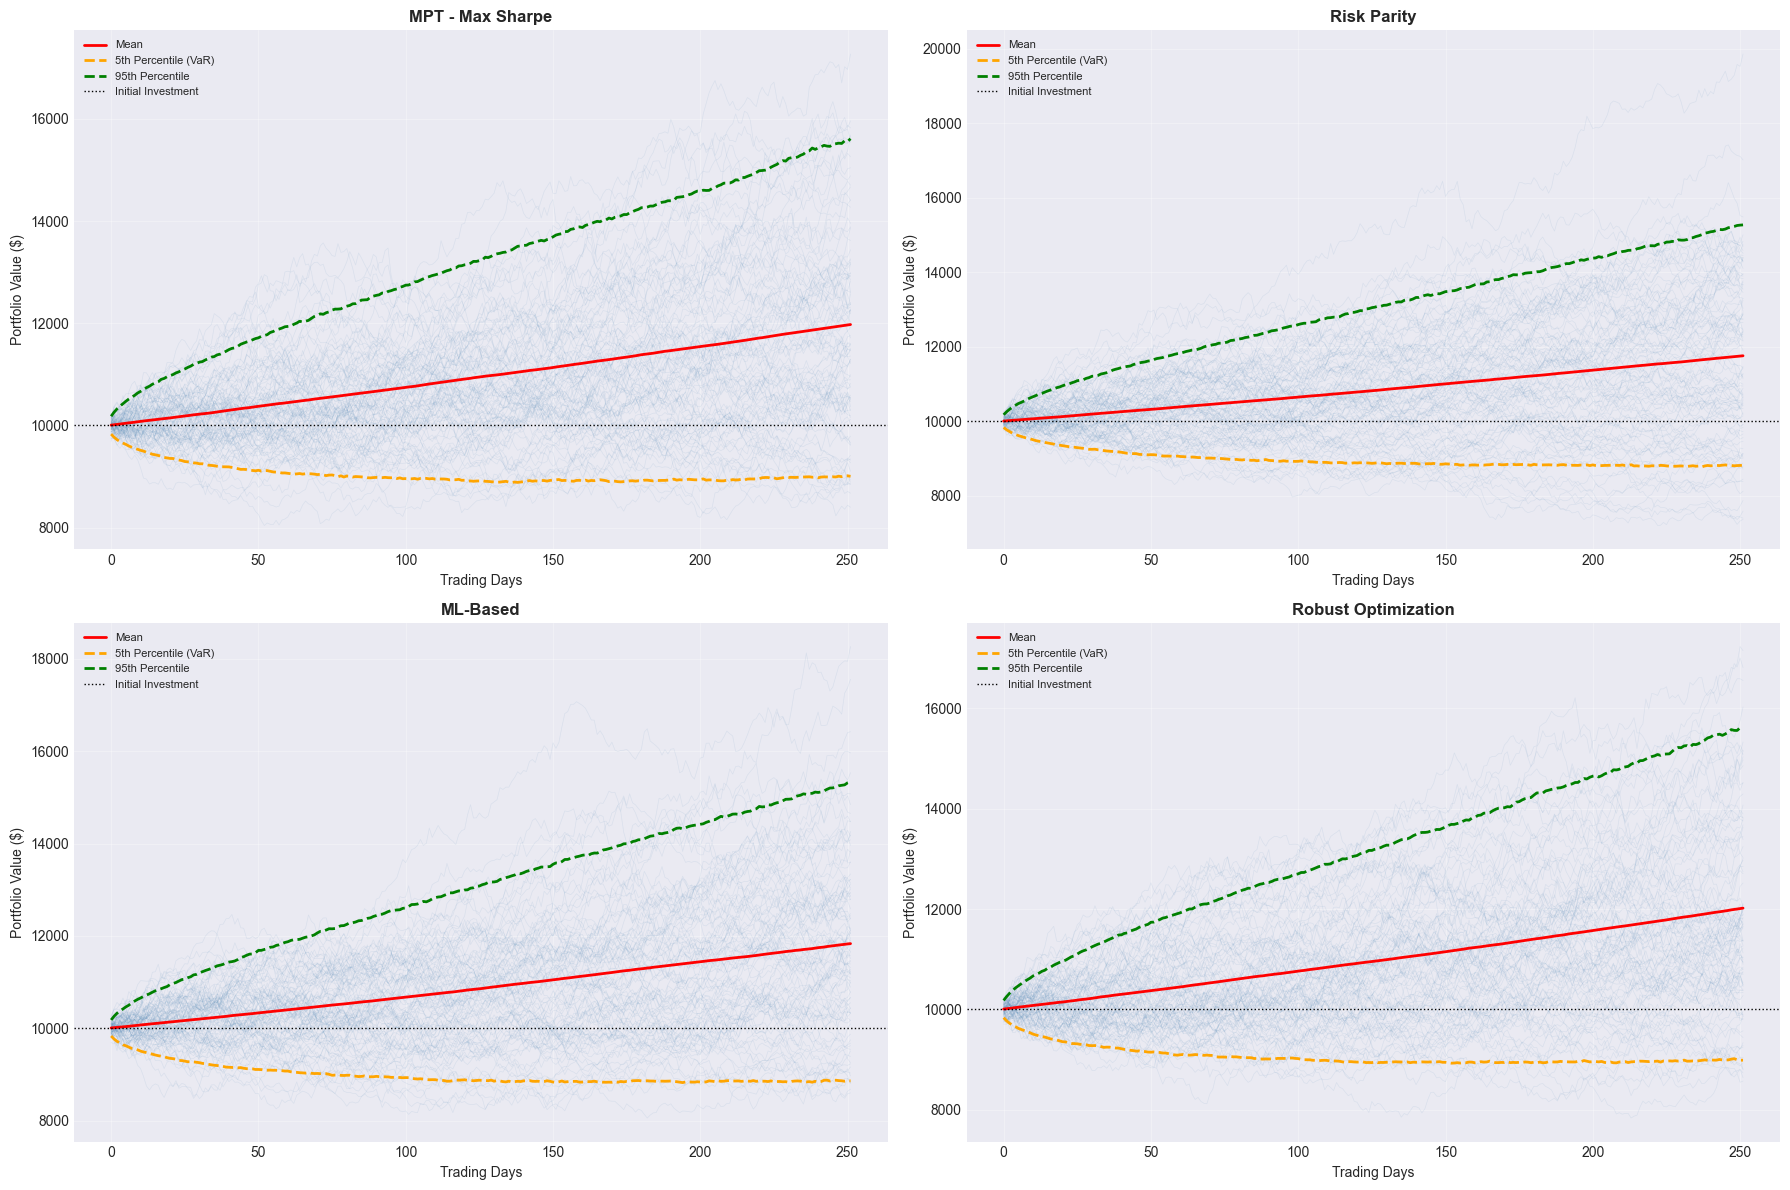

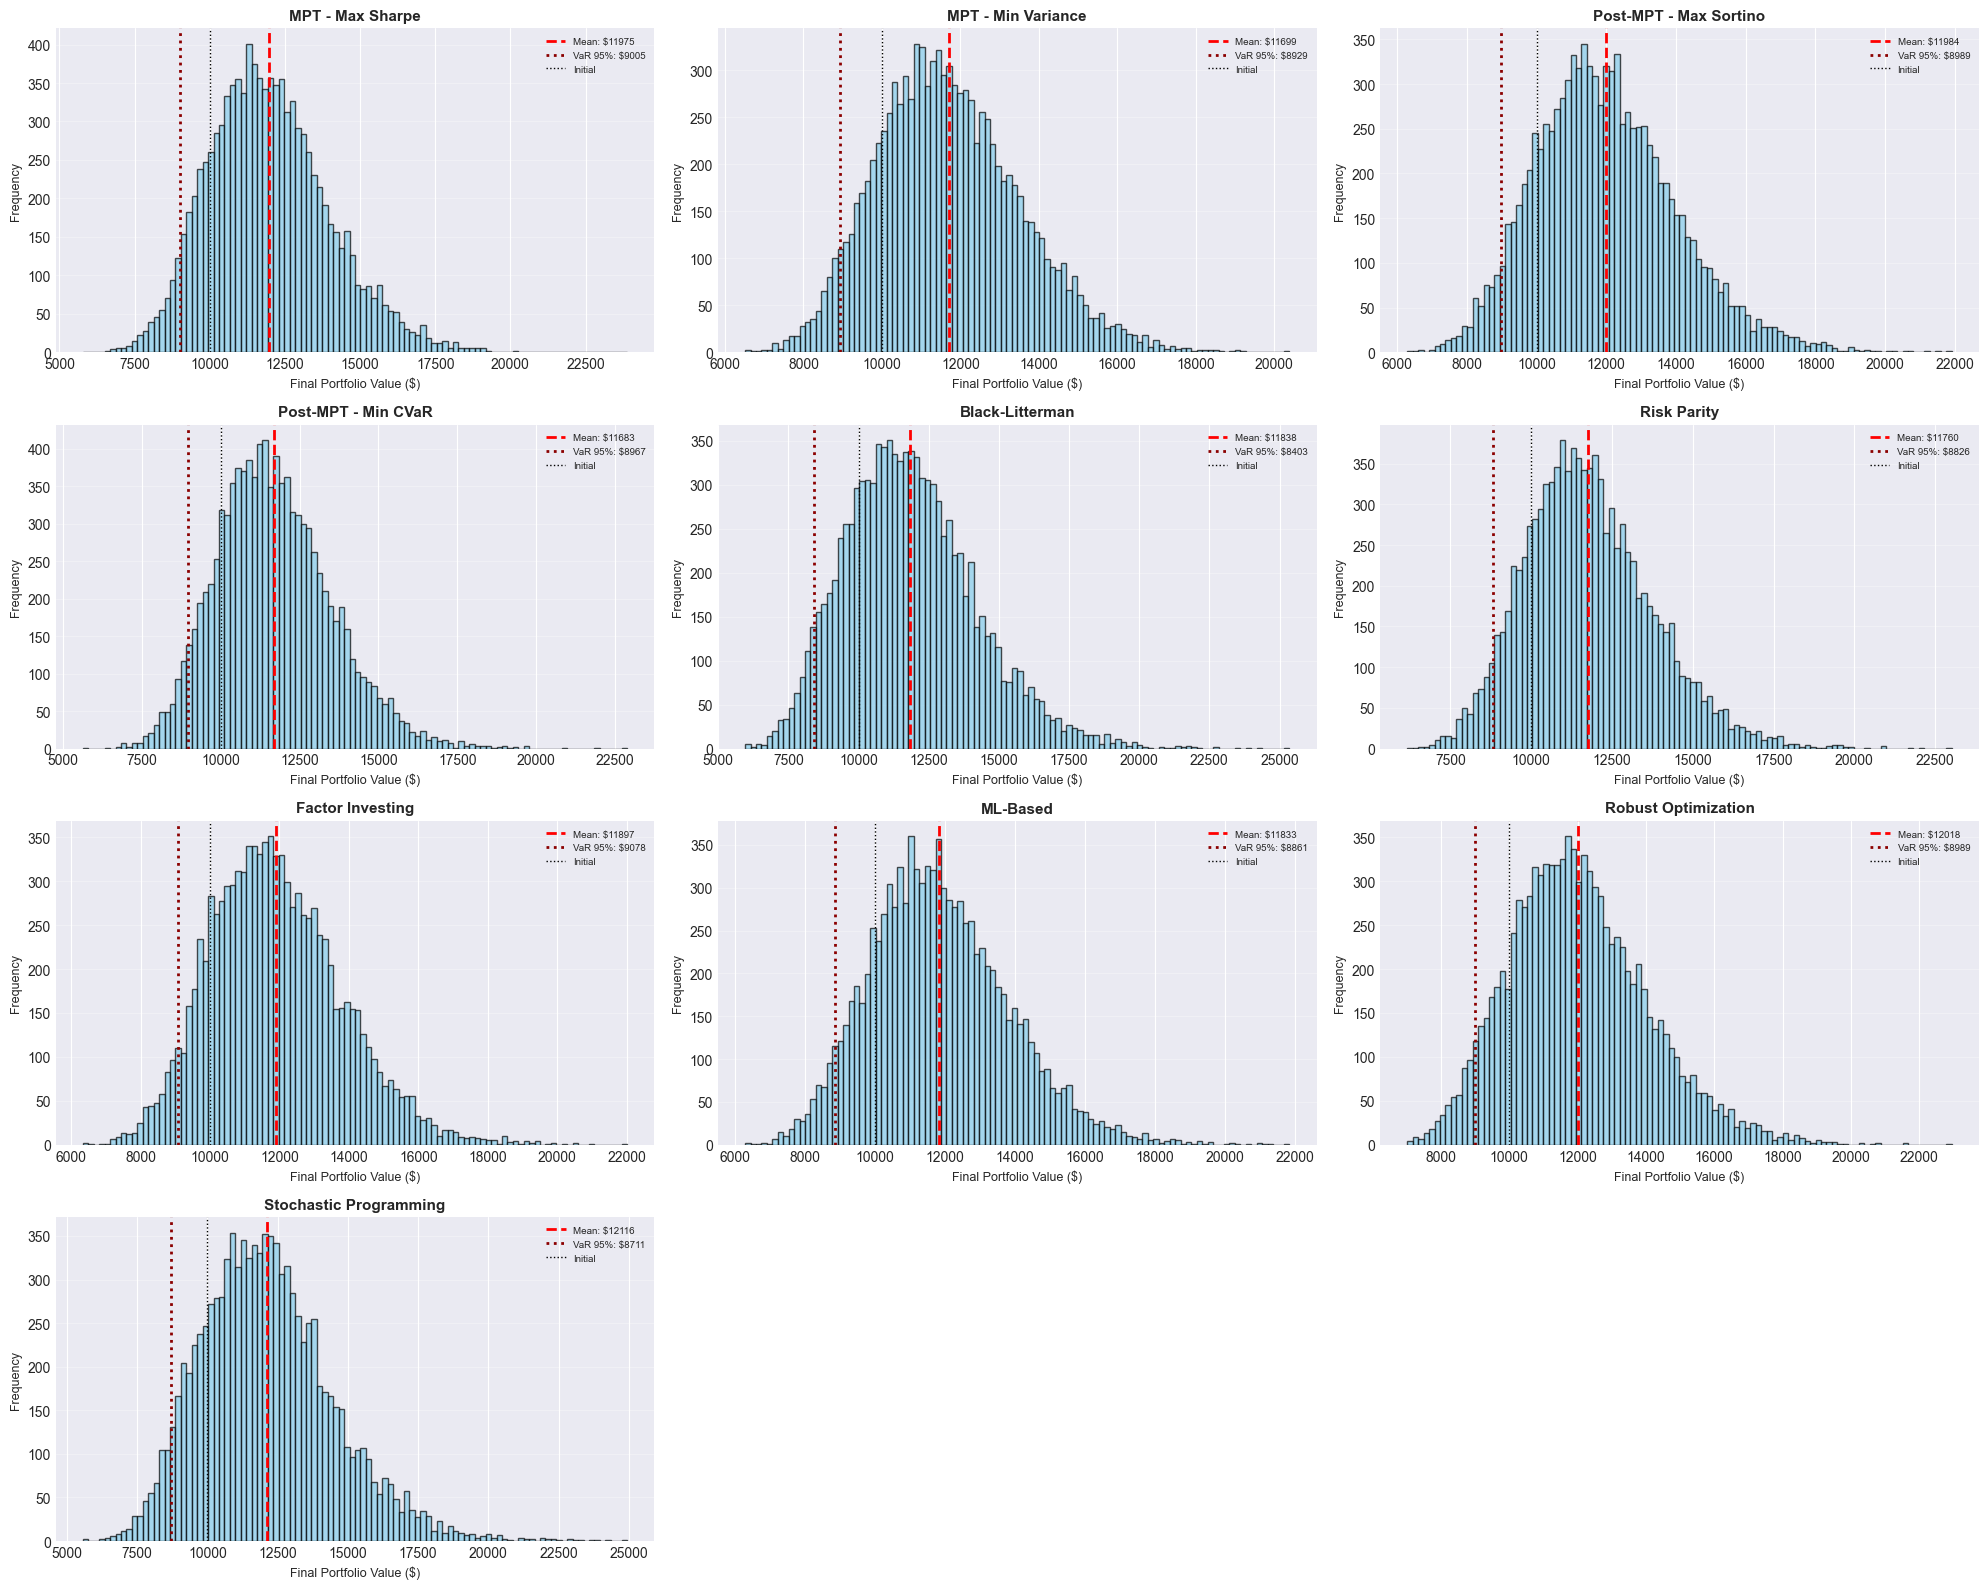

In [24]:
# Plot simulation paths for selected portfolios
selected_portfolios = ['MPT - Max Sharpe', 'Risk Parity', 'ML-Based', 'Robust Optimization']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

for idx, portfolio_name in enumerate(selected_portfolios):
    if portfolio_name not in simulation_results:
        continue
        
    ax = axes[idx // 2, idx % 2]
    data = simulation_results[portfolio_name]
    sims = data['simulations']
    
    # Plot sample paths
    for i in range(100):  # Plot 100 sample paths
        ax.plot(sims[:, i], alpha=0.1, color='steelblue', linewidth=0.5)
    
    # Plot mean and percentiles
    mean_path = np.mean(sims, axis=1)
    p5 = np.percentile(sims, 5, axis=1)
    p95 = np.percentile(sims, 95, axis=1)
    
    ax.plot(mean_path, color='red', linewidth=2, label='Mean')
    ax.plot(p5, color='orange', linewidth=2, linestyle='--', label='5th Percentile (VaR)')
    ax.plot(p95, color='green', linewidth=2, linestyle='--', label='95th Percentile')
    ax.axhline(y=initial_investment, color='black', linestyle=':', linewidth=1, label='Initial Investment')
    
    ax.set_title(portfolio_name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Trading Days', fontsize=10)
    ax.set_ylabel('Portfolio Value ($)', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('monte_carlo_simulations_selected.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot final value distributions for all portfolios
num_portfolios = len(simulation_results)
cols = 3
rows = (num_portfolios + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.flatten() if num_portfolios > 1 else [axes]

for idx, (portfolio_name, data) in enumerate(simulation_results.items()):
    if idx >= len(axes):
        break
        
    ax = axes[idx]
    final_values = data['final_values']
    results = data['results']
    
    ax.hist(final_values, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
    ax.axvline(x=results['Mean Final Value'], color='red', linestyle='--', linewidth=2, 
               label=f"Mean: ${results['Mean Final Value']:.0f}")
    ax.axvline(x=results['VaR 95%'], color='darkred', linestyle=':', linewidth=2, 
               label=f"VaR 95%: ${results['VaR 95%']:.0f}")
    ax.axvline(x=initial_investment, color='black', linestyle=':', linewidth=1, label='Initial')
    
    ax.set_title(portfolio_name, fontsize=11, fontweight='bold')
    ax.set_xlabel('Final Portfolio Value ($)', fontsize=9)
    ax.set_ylabel('Frequency', fontsize=9)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3, axis='y')

# Hide unused subplots
for idx in range(num_portfolios, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('final_value_distributions_all.png', dpi=300, bbox_inches='tight')
plt.show()

## Phase 5: Final Evaluation & Comparison

In [ ]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame(all_results)

print("=" * 120)
print("FINAL PORTFOLIO COMPARISON - MONTE CARLO SIMULATION RESULTS")
print("=" * 120)
print(comparison_df.to_string(index=False))

# Sort by different criteria
print("\n" + "=" * 120)
print("TOP 5 PORTFOLIOS BY DIFFERENT METRICS")
print("=" * 120)

print("\n📈 Highest Mean Return:")
print(comparison_df.nlargest(5, 'Mean Return (%)')[['Portfolio', 'Mean Return (%)', 'Std Dev', 'Probability of Profit (%)']].to_string(index=False))

print("\n🛡️ Lowest Risk (Std Dev):")
print(comparison_df.nsmallest(5, 'Std Dev')[['Portfolio', 'Std Dev', 'Mean Return (%)', 'VaR 95%']].to_string(index=False))

print("\n💎 Best Risk-Adjusted Return (Sharpe-like):")
comparison_df['Risk_Adjusted_Return'] = comparison_df['Mean Return (%)'] / (comparison_df['Std Dev'] / initial_investment * 100)
print(comparison_df.nlargest(5, 'Risk_Adjusted_Return')[['Portfolio', 'Risk_Adjusted_Return', 'Mean Return (%)', 'Std Dev']].to_string(index=False))

print("\n🎯 Highest Probability of Profit:")
print(comparison_df.nlargest(5, 'Probability of Profit (%)')[['Portfolio', 'Probability of Profit (%)', 'Mean Return (%)', 'CVaR 95%']].to_string(index=False))

# Comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(24, 18))

metrics = ['Mean Return (%)', 'Median Return (%)', 'Std Dev', 'VaR 95%', 'CVaR 95%', 
           'Probability of Profit (%)', 'Best Case', 'Worst Case', 'Risk_Adjusted_Return']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#A8E6CF', '#FFD3B6', '#FFAAA5']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    
    # Sort for better visualization
    sorted_df = comparison_df.sort_values(metric, ascending=(metric == 'Std Dev' or 'Worst' in metric))
    
    bars = ax.barh(sorted_df['Portfolio'], sorted_df[metric], color=colors[idx], alpha=0.8, edgecolor='black')
    ax.set_xlabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, v) in enumerate(zip(bars, sorted_df[metric])):
        ax.text(v, bar.get_y() + bar.get_height()/2, f'{v:.2f}', 
                ha='left', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('portfolio_comparison_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

# Final rankings
print("\n" + "=" * 120)
print("🏆 FINAL PORTFOLIO RANKINGS")
print("=" * 120)

rankings = {
    'Highest Mean Return': comparison_df.loc[comparison_df['Mean Return (%)'].idxmax(), 'Portfolio'],
    'Lowest Risk (Std Dev)': comparison_df.loc[comparison_df['Std Dev'].idxmin(), 'Portfolio'],
    'Best Risk-Adjusted Return': comparison_df.loc[comparison_df['Risk_Adjusted_Return'].idxmax(), 'Portfolio'],
    'Best VaR (95%)': comparison_df.loc[comparison_df['VaR 95%'].idxmax(), 'Portfolio'],
    'Best CVaR (95%)': comparison_df.loc[comparison_df['CVaR 95%'].idxmax(), 'Portfolio'],
    'Highest Probability of Profit': comparison_df.loc[comparison_df['Probability of Profit (%)'].idxmax(), 'Portfolio'],
    'Best Case Scenario': comparison_df.loc[comparison_df['Best Case'].idxmax(), 'Portfolio'],
    'Best Worst Case': comparison_df.loc[comparison_df['Worst Case'].idxmax(), 'Portfolio']
}

for criterion, winner in rankings.items():
    value = comparison_df.loc[comparison_df['Portfolio'] == winner].iloc[0]
    print(f"\n{criterion}: {winner}")
    if 'Return' in criterion:
        print(f"   Value: {value['Mean Return (%)']:.2f}%")
    elif 'Risk' in criterion:
        print(f"   Value: {value['Std Dev']:.2f}")
    elif 'Probability' in criterion:
        print(f"   Value: {value['Probability of Profit (%)']:.2f}%")

best_overall = comparison_df.loc[comparison_df['Risk_Adjusted_Return'].idxmax(), 'Portfolio']

print("\n" + "=" * 120)
print("? BEST OVERALL PORTFOLIO (Risk-Adjusted Return)")
print("=" * 120)
best_row = comparison_df.loc[comparison_df['Risk_Adjusted_Return'].idxmax()]
print(f"\nPortfolio: {best_overall}")
print(f"  Mean Return: {best_row['Mean Return (%)']:.2f}%")
print(f"  Std Dev: ${best_row['Std Dev']:.2f}")
print(f"  Risk-Adjusted Score: {best_row['Risk_Adjusted_Return']:.4f}")
print(f"  VaR (95%): ${best_row['VaR 95%']:.2f}")
print(f"  Probability of Profit: {best_row['Probability of Profit (%)']:.2f}%")

print("\n" + "=" * 120)
print("📊 SUMMARY")
print("=" * 120)
print(f"✓ Analyzed {len(selected_tickers)} stocks (1980-2022)")
print(f"✓ Trained 5 prediction models (LR, ARIMA, Prophet, Black-Scholes, Hybrid)")
print(f"✓ Optimized {len(portfolios_to_test)} portfolios:")
print(f"   • 2 MPT (Max Sharpe, Min Variance)")
print(f"   • 2 Post-MPT (Max Sortino, Min CVaR)")
print(f"   • 6 Advanced (Black-Litterman, Risk Parity, Factor, ML, Robust, Stochastic)")
print(f"✓ Ran {num_simulations:,} Monte Carlo simulations per portfolio")
print(f"✓ Initial investment: ${initial_investment:,}")
print(f"✓ Simulation period: {num_days} trading days (1 year)")

print("\n📋 RECOMMENDATIONS BY INVESTOR PROFILE:")
print(f"   Conservative (Low Risk): {rankings['Lowest Risk (Std Dev)']}")
print(f"   Balanced (Risk-Adjusted): {best_overall}")
print(f"   Aggressive (Max Returns): {rankings['Highest Mean Return']}")
print(f"   Risk-Averse (Best Downside): {rankings['Best CVaR (95%)']}")

print("\n✓ Portfolio optimization and simulation complete!")